# 通し課題① Kickstarter Projects（二値分類）
https://www.kaggle.com/kemical/kickstarter-projects  
あるクラウドファンデイングが成功するか(state)を事前に予測するモデルを構築する

参考サイト  
https://tanuhack.com/python/basic-data-analysis/  
https://qiita.com/0NE_shoT_/items/b702ab482466df6e5569
http://robonchu.hatenablog.com/entry/2017/10/15/112724

## 更新履歴 
2019/09/04（Day1後提出分）  
　・課題開始  
    
2019/09/11（Day2後提出分）  
　・欠損行の確認タイミングを変更  
　・外れ値の除去  
　・ダミー変数処理の追加
　・ホールドアウト法でモデル検証  
  
　　[課題]  
　　　・nameも説明変数として使いたい → 単語を拾ってくるとかは可能？  
　　　・categoryも説明変数として使える？  
　　　・学習にSVMを使うパターンも要検証  
  
2019/09/26（Day3後提出分）  
　・評価基準統一のための処理を追加  
　・L1正則化による特徴選択を追加  
　・ランダムフォレスト、ニューラルネットワークの追加
 

In [280]:
#### ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.metrics import log_loss, mean_absolute_error, accuracy_score, confusion_matrix, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

In [240]:
# データ取り込み
df_kp = pd.read_csv("./data/ks-projects-201801.csv")

# データ確認
display(df_kp.head(10))
df_kp.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [241]:
# データの構成を確認
df_kp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


ID : ID  
name : プロジェクトの名前  
category : カテゴリ  
main_category : キャンペーンのカテゴリ  
currency : 通貨  
deadline : 締め切り  
goal : 目標金額  
launched : 発売日（クラウドファンディング開始日？）  
pledged : 誓約金額  
state : 状態  
backers : 支援者数  
country : 誓約した国  
usd pledged : 誓約金額の米ドル換算(kickstarterからの変換)  
usd_pledged_real : 誓約金額の米ドル換算 (Fixer.io APIからの変換)   
usd_goal_real : 目標金額の米ドル換算 (Fixer.io APIからの変換)

In [242]:
# プロジェクト開始前に知ることのできないデータの列は削除
# [pledged : 誓約金額]
# [backers : 支援者数]
# [usd pledged : 誓約金額の米ドル換算(kickstarterからの変換)]
# [usd_pledged_real : 誓約金額の米ドル換算 (Fixer.io APIからの変換)]
dropCol = ['pledged', 'backers', 'usd pledged', 'usd_pledged_real']
df_kp = df_kp.drop(dropCol, axis=1)

# 分析に不要そうなデータの列を削除
# [ID : ID]
# [name : プロジェクトの名前]
# [goal : 目標金額] => 米ドルで統一されたusd_goal_realがあるため不要では？
dropCol = ['ID', 'name', 'goal']
df_kp = df_kp.drop(dropCol, axis=1)

In [243]:
# 欠損値(NaN)の確認
df_kp.isnull().sum()

category         0
main_category    0
currency         0
deadline         0
launched         0
state            0
country          0
usd_goal_real    0
dtype: int64

　→ 欠損なし

In [244]:
# 成功1 それ以外0
#df_kp['state'] = (df_kp['state'] == 'successful').astype(int)
# 評価基準統一のための処理
df_kp = df_kp[df_kp["state"]!="live"]
df_kp["state"] = df_kp["state"]=="successful"

# 募集期間も成功可否に関係しそうなので算出する（開始日～締め切りの日数）
df_kp['period'] = (pd.to_datetime(df_kp['deadline']).dt.date - pd.to_datetime(df_kp['launched']).dt.date).dt.days
# 期間があれば開始日・締め切りそのものは不要では？
dropCol = ['deadline', 'launched']
df_kp = df_kp.drop(dropCol, axis=1)

In [245]:
# LabelEncoderで文字データを数値に変換
leClass = LabelEncoder()
df_kp["category"] = leClass.fit_transform(df_kp["category"])
df_kp["main_category"] = leClass.fit_transform(df_kp["main_category"])
df_kp["currency"] = leClass.fit_transform(df_kp["currency"])
df_kp["country"] = leClass.fit_transform(df_kp["country"])

In [246]:
# データ確認
display(df_kp.head(10))
# 相関係数
display(df_kp.corr())

,category,main_category,currency,state,country,usd_goal_real,period
0,108,12,5,False,9,1533.95,59
1,93,6,13,False,22,30000.00,60
2,93,6,13,False,22,45000.00,45
3,90,10,13,False,22,5000.00,30
4,55,6,13,False,22,19500.00,56
5,123,7,13,True,22,50000.00,35
6,58,7,13,True,22,1000.00,20
7,41,7,13,False,22,25000.00,45
8,113,4,13,False,22,125000.00,35
9,39,6,13,False,22,65000.00,30


,category,main_category,currency,state,country,usd_goal_real,period
category,1.000000,0.199050,-0.012244,0.022527,-0.012834,0.002602,-0.001292
main_category,0.199050,1.000000,-0.013885,-0.034920,-0.014283,0.002315,0.007040
currency,-0.012244,-0.013885,1.000000,0.066073,0.979507,-0.003695,0.005702
state,0.022527,-0.034920,0.066073,1.000000,0.064518,-0.023246,-0.025708
country,-0.012834,-0.014283,0.979507,0.064518,1.000000,-0.002975,0.005975
usd_goal_real,0.002602,0.002315,-0.003695,-0.023246,-0.002975,1.000000,0.004202
period,-0.001292,0.007040,0.005702,-0.025708,0.005975,0.004202,1.000000


In [247]:
# 散布図（全件処理すると時間がかかるため、ランダムに10000件）
#pd.plotting.scatter_matrix(df_kp.sample(10000), figsize=(16,16))
#plt.show()

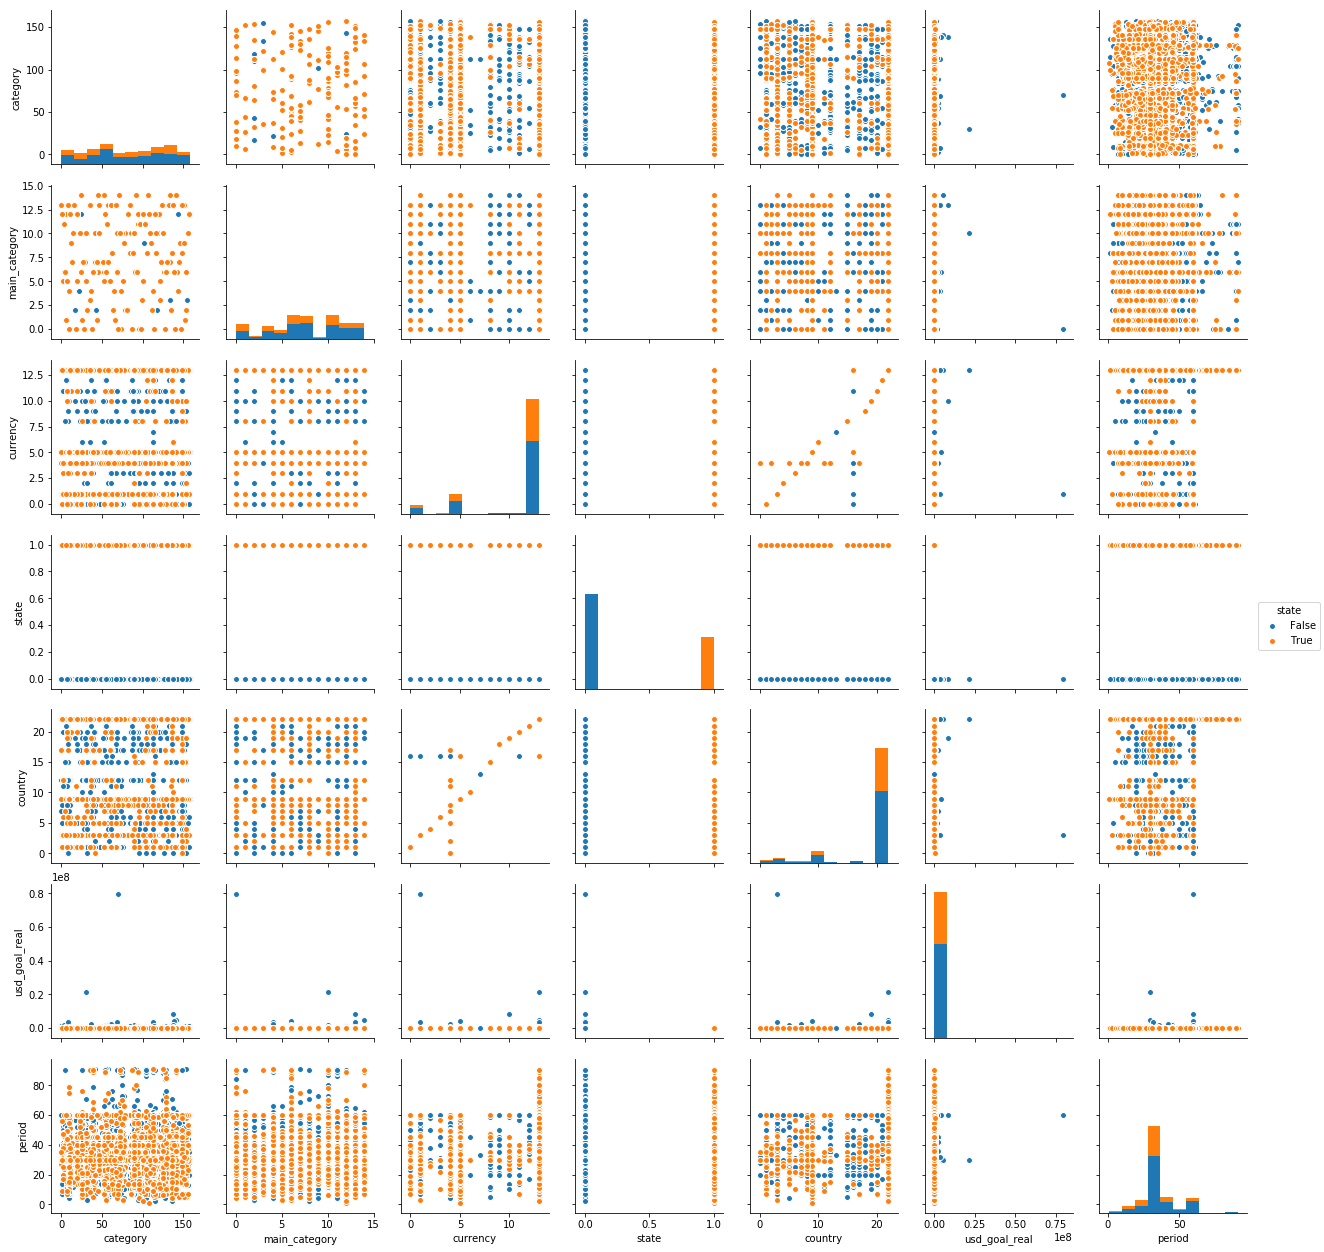

In [248]:
# 散布図行列（全件処理すると時間がかかるため、ランダムに10000件）
sns.pairplot(df_kp.sample(10000), hue='state')
plt.show()

[usd_goal_real : 目標金額]が高いデータには、[state : 状態]が1のデータがない  
　= 目標金額が高額だと成功しない

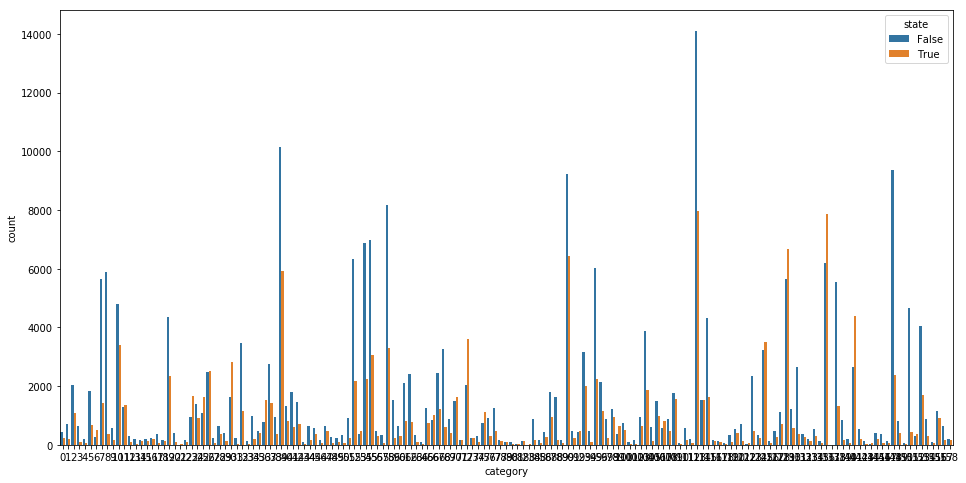

In [249]:
# カテゴリと成功/失敗の関係
plt.figure(figsize=(16,8))
sns.countplot(x='category', data=df_kp, hue='state')

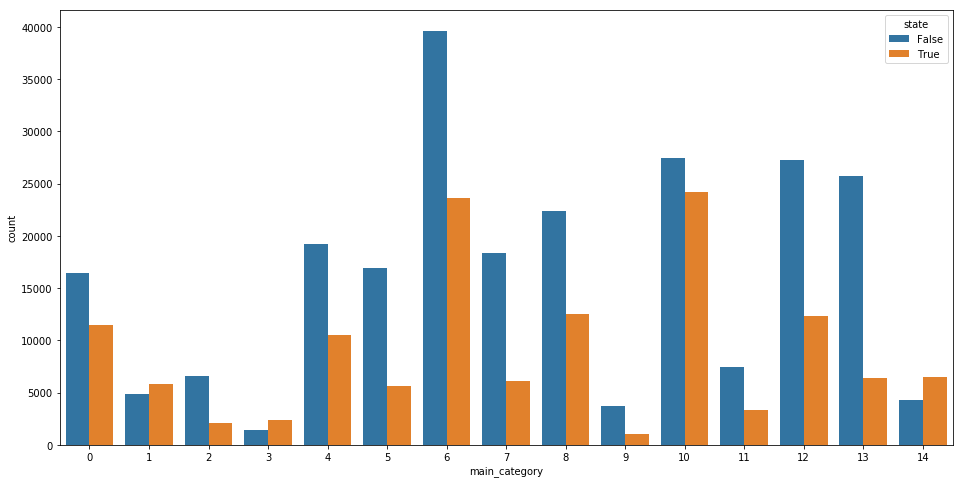

In [250]:
# キャンペーンのカテゴリと成功/失敗の関係
plt.figure(figsize=(16,8))
sns.countplot(x='main_category', data=df_kp, hue='state')

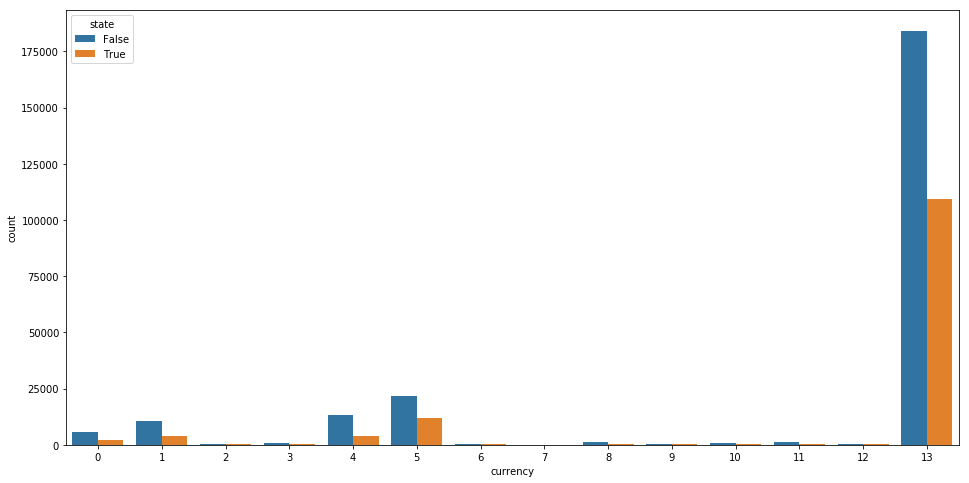

In [251]:
# 通貨と成功/失敗の関係
plt.figure(figsize=(16,8))
sns.countplot(x='currency', data=df_kp, hue='state')

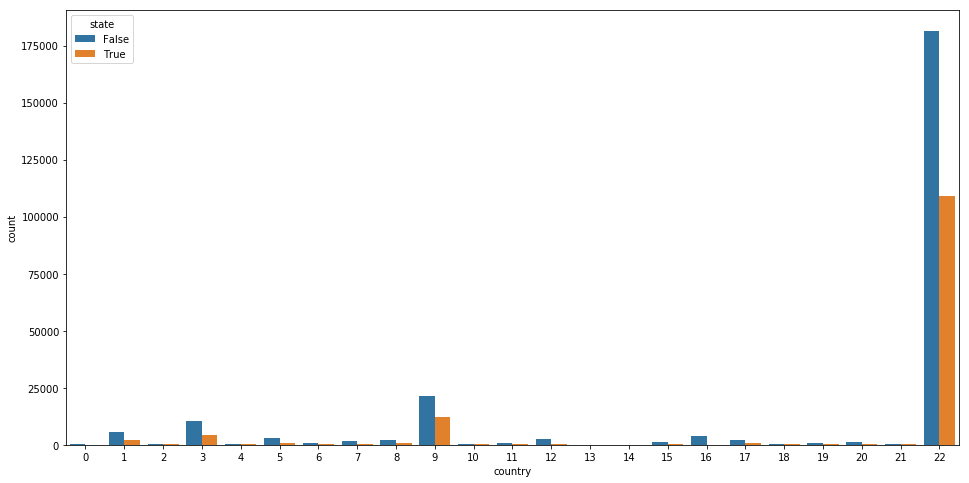

In [252]:
# 国と成功/失敗の関係
plt.figure(figsize=(16,8))
sns.countplot(x='country', data=df_kp, hue='state')

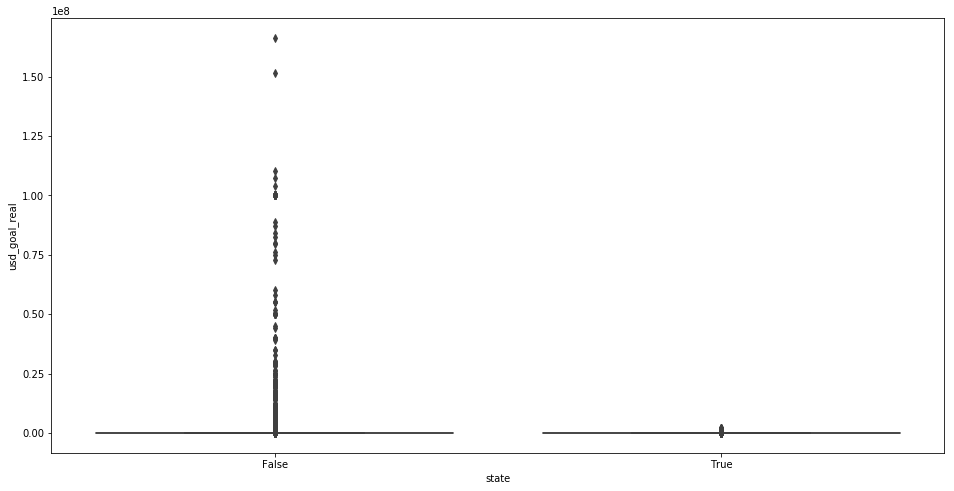

In [253]:
# 目標金額と成功/失敗の関係
plt.figure(figsize=(16,8))
sns.boxplot(df_kp['state'], df_kp['usd_goal_real'])

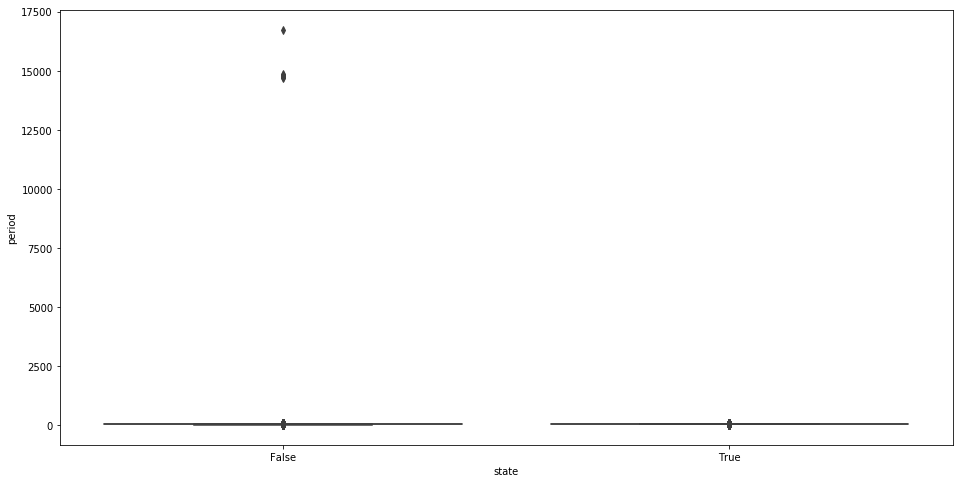

In [254]:
# 募集期間と成功/失敗の関係
plt.figure(figsize=(16,8))
sns.boxplot(df_kp['state'], df_kp['period'])

### データについて  
* cateory,main_category : カテゴリによる成功/失敗の傾向はありそうだが、categoryは細分化されすぎている  
分類するならmain_categoryのほうが使えそう
* currency : 通貨によって成功/失敗が決まることはなさそう？データに偏りがあるのが気になる
* country : 国によって成功/失敗が決まることはなさそう？データに偏りがあるのが気になる
* usd_goal_real : 目標金額と成功/失敗は相関がありそうだが、外れ値がある
* period : 募集期間と成功/失敗は相関がありそうだが、外れ値がある

In [255]:
# 欠損値(NaN)がひとつでも含まれている行を削除する（欠損値無しのはず）
#df_kp = df_kp.dropna()

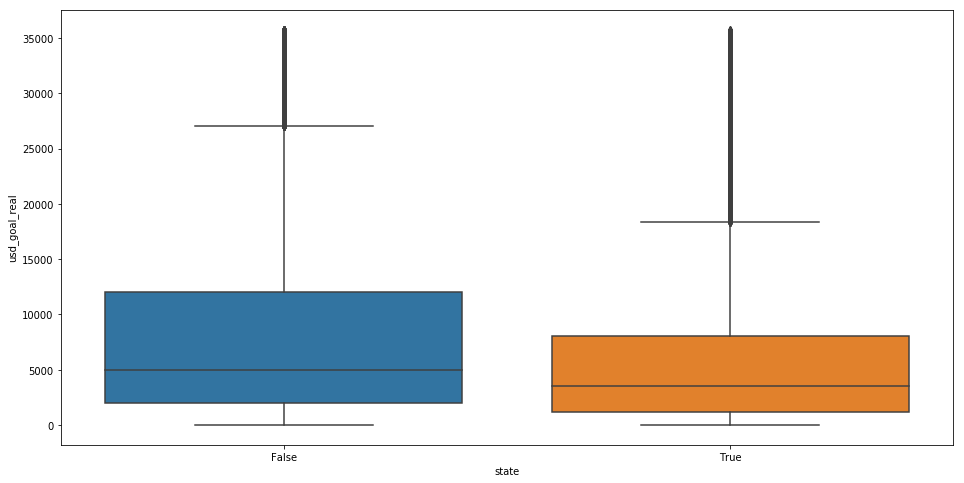

In [256]:
### 外れ値を除去 ####
# 四分位範囲を計算
distance = 1.5 * (np.percentile(df_kp['usd_goal_real'], 75) - np.percentile(df_kp['usd_goal_real'], 25))
df_kp.drop(df_kp[df_kp['usd_goal_real'] > distance + np.percentile(df_kp['usd_goal_real'], 75)].index, inplace=True)
df_kp.drop(df_kp[df_kp['usd_goal_real'] < np.percentile(df_kp['usd_goal_real'], 25) - distance].index, inplace=True)

# 確認
plt.figure(figsize=(16,8))
sns.boxplot(df_kp['state'], df_kp['usd_goal_real'])

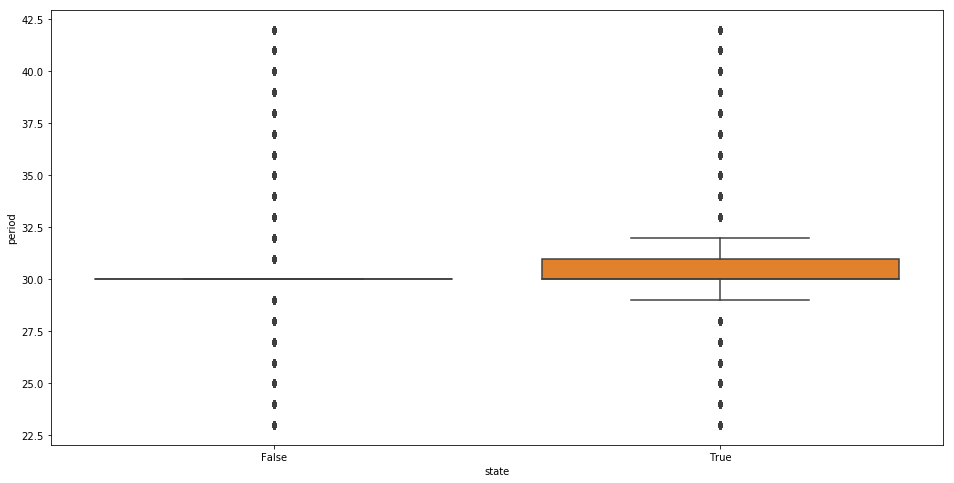

In [257]:
### 外れ値を除去 ####
# 四分位範囲を計算
distance = 1.5 * (np.percentile(df_kp['period'], 75) - np.percentile(df_kp['period'], 25))
df_kp.drop(df_kp[df_kp['period'] > distance + np.percentile(df_kp['period'], 75)].index, inplace=True)
df_kp.drop(df_kp[df_kp['period'] < np.percentile(df_kp['period'], 25) - distance].index, inplace=True)

# 確認
plt.figure(figsize=(16,8))
sns.boxplot(df_kp['state'], df_kp['period'])

In [258]:
# ダミー変数に変換
# categoryは細分化されすぎているので保留
#dummy_category = pd.get_dummies(df_kp['category'])
dummy_maincategory = pd.get_dummies(df_kp['main_category'], prefix='main_category')
# currency,countryは成功/失敗への影響度が低そう データに偏りもあるので保留
#dummy_country = pd.get_dummies(df_kp['country'], prefix='country')
#dummy_currency = pd.get_dummies(df_kp['currency'], prefix='currency')

dropCol = ['category', 'main_category', 'currency', 'country']
df_kp = df_kp.drop(dropCol, axis=1)
df_kp = pd.concat([df_kp, dummy_maincategory], axis=1)

In [259]:
# 欠損値を含む行や、0のみの列がないことを確認
display(df_kp.isnull().sum())
df_kp.sum()

state               0
usd_goal_real       0
period              0
main_category_0     0
main_category_1     0
main_category_2     0
main_category_3     0
main_category_4     0
main_category_5     0
main_category_6     0
main_category_7     0
main_category_8     0
main_category_9     0
main_category_10    0
main_category_11    0
main_category_12    0
main_category_13    0
main_category_14    0
dtype: int64

state               8.969100e+04
usd_goal_real       1.824589e+09
period              7.063747e+06
main_category_0     1.748700e+04
main_category_1     7.748000e+03
main_category_2     6.085000e+03
main_category_3     2.335000e+03
main_category_4     1.773500e+04
main_category_5     1.537100e+04
main_category_6     3.473200e+04
main_category_7     1.433800e+04
main_category_8     2.212000e+04
main_category_9     2.714000e+03
main_category_10    3.307000e+04
main_category_11    6.828000e+03
main_category_12    2.696700e+04
main_category_13    1.529700e+04
main_category_14    6.445000e+03
dtype: float64

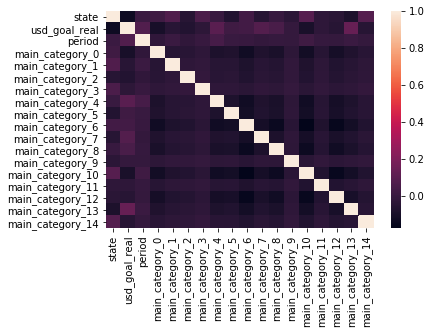

In [260]:
# ヒートマップ
sns.heatmap(df_kp.corr())
plt.show()

### 訓練誤差と汎化誤差の評価  
データ件数が多いので、実装が簡単なホールドアウト法で実装
- ホールドアウト法 : データを事前に学習用とテスト用に分割し、テスト用データで学習済みモデルの汎化誤差を評価する方法のこと

In [261]:
# 全件処理すると時間がかかるため、ランダムに30000件
df_kp_sample = df_kp.sample(30000, random_state=1234)

y = df_kp_sample['state'].values
# scikit-learnに入力するために整形
X = df_kp_sample.drop('state', axis=1).values
# 全データのうち、何%をテストデータにするか（20%に設定）
test_size = 0.2
# ホールドアウト法を実行（テストデータはランダム選択）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

- `X_train` : 学習用データの説明変数
- `X_test` : テスト用データの説明変数
- `y_train` : 学習用データの目的変数
- `y_test` : テスト用データの目的変数

### 前処理

In [262]:
# 標準化
stdsc = StandardScaler()

X_train = stdsc.fit_transform(X_train)
#X_test = stdsc.fit_transform(X_test)
X_test = stdsc.transform(X_test)

#### L1正則化による特徴選択

In [263]:
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
# LassoCV : 交差検証によってL1正則化のハイパーパラメータを決定する関数
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

# fitで特徴選択を実行
sfm.fit(X_train, y_train)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False),
        norm_order=1, prefit=False, threshold=1e-05)

In [264]:
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True])

In [265]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
df_kp.drop('state', axis=1).columns[removed_idx]

Index(['main_category_0', 'main_category_8'], dtype='object')

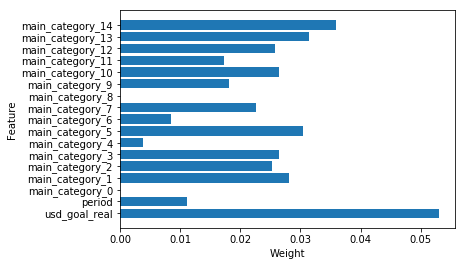

In [266]:
# LASSOで得た各特徴の係数の値を確認してみよう
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
# 係数を棒グラフで表示
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=df_kp.drop('state', axis=1).columns.values)
plt.xlabel("Weight") # 重み
plt.ylabel("Feature") # 変数
plt.show()

In [267]:
# 削除すべきと判断された列を削除し、再度分割
df_kp = df_kp.drop(df_kp.drop('state', axis=1).columns[removed_idx], axis=1)


# 全件処理すると時間がかかるため、ランダムに30000件
df_kp_sample = df_kp.sample(30000, random_state=1234)
y = df_kp_sample['state'].values
# scikit-learnに入力するために整形
X = df_kp_sample.drop('state', axis=1).values
# 全データのうち、何%をテストデータにするか（20%に設定）
test_size = 0.2
# ホールドアウト法を実行（テストデータはランダム選択）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

# 標準化
stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.transform(X_test)

### 学習

#### ロジスティック回帰

In [268]:
%%time
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X_train, y_train)

Wall time: 30.2 s


In [269]:
# ラベルを予測
y_pred = clf.predict(X_test)

print("対数尤度 = {:.3f}".format(- log_loss(y_test, y_pred)))

# 正答率を計算
accuracy =  accuracy_score(y_test, y_pred)
print('正答率（Accuracy）  = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall）    = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score）    = {:.3f}%'.format(100 * f1_score[0]))

対数尤度 = -12.895
正答率（Accuracy）  = 62.667%
適合率（Precision） = 63.775%
再現率（Recall）    = 88.800%
F1値（F1-score）    = 74.235%


In [270]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = 成功以外', '正解 = 成功'], 
                        columns=['予測 = 成功以外', '予測 = 成功'])
conf_mat

,予測 = 成功以外,予測 = 成功
正解 = 成功以外,3227,407
正解 = 成功,1833,533


#### ランダムフォレスト

score= 0.611125
[0.39210607 0.18431883 0.         0.01703015 0.03035157 0.
 0.05538495 0.         0.         0.         0.0659798  0.
 0.06828374 0.02755162 0.15899326]


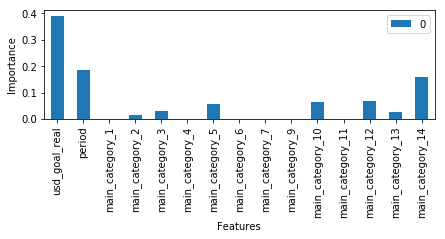

In [272]:
clf = RandomForestClassifier(n_estimators=10, max_depth=2, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=df_kp_sample.drop('state', axis=1).columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

In [275]:
# ラベルを予測
y_pred = clf.predict(X_test)

print("対数尤度 = {:.3f}".format(- log_loss(y_test, y_pred)))

# 正答率を計算
accuracy =  accuracy_score(y_test, y_pred)
print('正答率（Accuracy）  = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall）    = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score）    = {:.3f}%'.format(100 * f1_score[0]))

対数尤度 = -13.459
正答率（Accuracy）  = 61.033%
適合率（Precision） = 60.972%
再現率（Recall）    = 99.092%
F1値（F1-score）    = 75.493%


 → Recallがかなり高い

In [276]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = 成功以外', '正解 = 成功'], 
                        columns=['予測 = 成功以外', '予測 = 成功'])
conf_mat

,予測 = 成功以外,予測 = 成功
正解 = 成功以外,3601,33
正解 = 成功,2305,61


#### ニューラルネットワーク

In [287]:
# one-hotベクトルに変換
y_train_NN = np_utils.to_categorical(y_train)
y_test_NN = np_utils.to_categorical(y_test)

In [294]:
model = Sequential()
model.add(Dense(6, activation='relu', input_dim=15))
# model.add(Dense(5, activation='relu', input_dim=6))
model.add(Dense(2, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

Train on 24000 samples, validate on 6000 samples
Epoch 1/50
24000/24000 [==============================] - 1s 52us/step - loss: 0.6553 - acc: 0.6154 - val_loss: 0.6441 - val_acc: 0.6227
Epoch 2/50
24000/24000 [==============================] - 1s 39us/step - loss: 0.6476 - acc: 0.6217 - val_loss: 0.6487 - val_acc: 0.6225
Epoch 3/50
24000/24000 [==============================] - 1s 39us/step - loss: 0.6466 - acc: 0.6250 - val_loss: 0.6450 - val_acc: 0.6207
Epoch 4/50
24000/24000 [==============================] - 1s 39us/step - loss: 0.6465 - acc: 0.6235 - val_loss: 0.6455 - val_acc: 0.6228
Epoch 5/50
24000/24000 [==============================] - 1s 39us/step - loss: 0.6460 - acc: 0.6242 - val_loss: 0.6438 - val_acc: 0.6230
Epoch 6/50
24000/24000 [==============================] - 1s 38us/step - loss: 0.6452 - acc: 0.6250 - val_loss: 0.6417 - val_acc: 0.6268
Epoch 7/50
24000/24000 [==============================] - 1s 37us/step - loss: 0.6442 - acc: 0.6255 - val_loss: 0.6397 - val_acc:

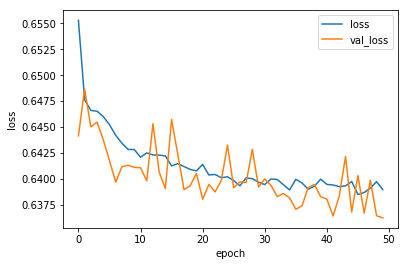

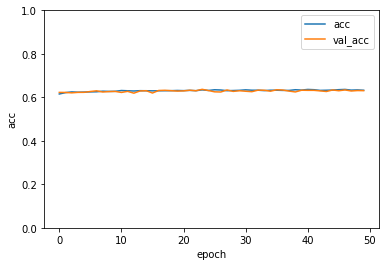

In [295]:
# 計算の実行
fit = model.fit(X_train, y_train_NN,
          epochs=50,
          batch_size=20,validation_data=(X_test, y_test_NN))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()